📊 Loading submission template from: ../data/raw/Submission_template.csv
📊 Loading original dataset to match coordinates...
✅ Original dataset loaded with 16 columns
📌 Available columns: datetime, longitude, latitude, uhi_index, land_surface_temp, band1, band2, band3, band4, air_temp_at_surface_, relative_humidity_, avg_wind_speed_, wind_direction_, solar_flux_, nearest_building_lon, nearest_building_lat
🔍 Matching coordinates and merging necessary features...
🔄 Loading model and feature list...
✅ Feature list loaded with 25 features
⚙️ Applying feature engineering pipeline with available data...
📌 Available columns after matching: 16
📅 Applying temporal feature engineering...
🌤️ Applying weather feature engineering...
  - Creating temp_gradient from land_surface_temp and air_temp_at_surface_
  - Creating humidity_temp_interaction from relative_humidity_ and air_temp_at_surface_
  - Creating wind_temp_interaction from avg_wind_speed_ and air_temp_at_surface_
  - Creating solar_temp_inte

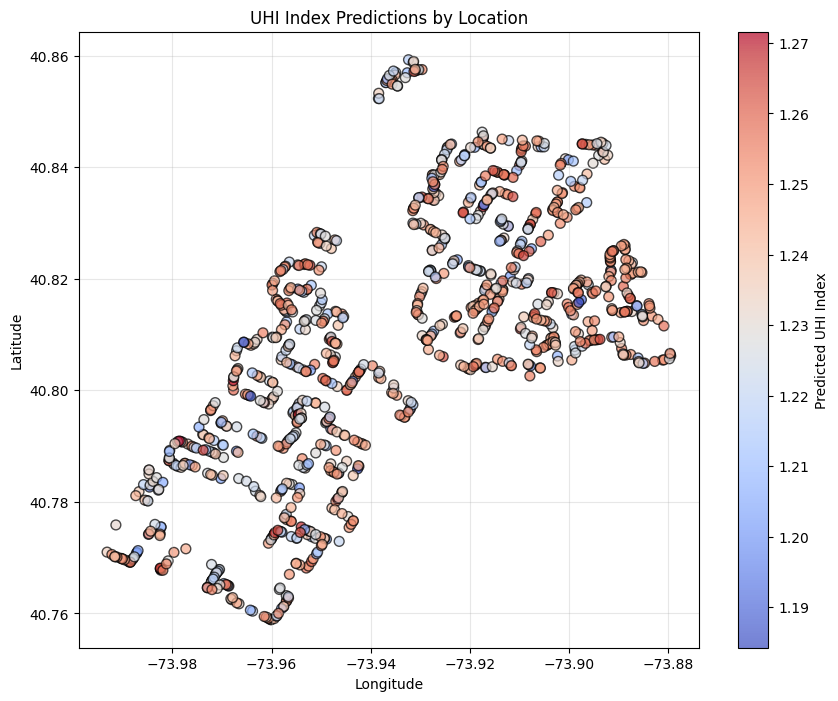

📈 Visualization saved to: ../data/submission_vidit_visualization.png

📊 Prediction Statistics:
Min UHI Index: 1.1843
Max UHI Index: 1.2716
Mean UHI Index: 1.2371
Median UHI Index: 1.2401


In [28]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import KNNImputer

def generate_submission(input_file_path, output_file_path, model_path="../models/UHI_best_model.pkl",
                        scaler_path="../models/scaler.pkl", 
                        feature_list_path="../data/processed/UHI_Weather_Building_Sentinel_LST_Featured_Cleaned.csv",
                        original_data_path="../data/processed/UHI_Weather_Building_Sentinel_LST_Merged.csv"):
    """
    Generate predictions for UHI index based on latitude and longitude with robust handling of missing columns.
    
    Args:
        input_file_path (str): Path to the input CSV file with 'latitude', 'longitude', and empty 'uhi_index'
        output_file_path (str): Path to save the submission CSV file with predictions
        model_path (str): Path to the saved model
        scaler_path (str): Path to the saved scaler
        feature_list_path (str): Path to the CSV with feature list
        original_data_path (str): Path to the original dataset
    """
    print(f"📊 Loading submission template from: {input_file_path}")
    
    # Load the submission template
    submission_df = pd.read_csv(input_file_path)
    
    # Ensure required columns exist
    required_cols = ['latitude', 'longitude']
    for col in required_cols:
        if col not in submission_df.columns:
            raise ValueError(f"Required column '{col}' not found in input file")
    
    # Load the original dataset to get available data
    print("📊 Loading original dataset to match coordinates...")
    try:
        original_df = pd.read_csv(original_data_path)
        # Standardize column names
        original_df.columns = original_df.columns.str.strip().str.lower().str.replace(" ", "_")
        print(f"✅ Original dataset loaded with {len(original_df.columns)} columns")
        print(f"📌 Available columns: {', '.join(original_df.columns.tolist())}")
    except FileNotFoundError:
        print(f"⚠️ Original dataset not found at {original_data_path}. Creating minimal dataset.")
        original_df = submission_df.copy()
    
    # ------------ Step 1: Match coordinates and merge data ------------
    print("🔍 Matching coordinates and merging necessary features...")
    
    # Function to find closest match in original dataset
    def find_closest_match(lat, lon, original_df):
        if 'latitude' in original_df.columns and 'longitude' in original_df.columns:
            # Calculate Euclidean distance between points
            original_df['distance'] = np.sqrt(
                (original_df['latitude'] - lat)**2 + 
                (original_df['longitude'] - lon)**2
            )
            # Get the index of the closest match
            closest_idx = original_df['distance'].idxmin()
            # Return the row without the distance column
            matched_row = original_df.loc[closest_idx].drop('distance')
            return matched_row
        else:
            # If original_df doesn't have coordinates, return a row with lat/lon only
            return pd.Series({'latitude': lat, 'longitude': lon})
    
    # Apply the function to each row in submission_df
    matched_data = []
    for _, row in submission_df.iterrows():
        matched_row = find_closest_match(row['latitude'], row['longitude'], original_df)
        matched_data.append(matched_row)
    
    # Create a new dataframe from matched data
    matched_df = pd.DataFrame(matched_data)
    
    # ------------ Step 2: Load Feature List and Model ------------
    print("🔄 Loading model and feature list...")
    
    # Load the feature list from the training data
    try:
        feature_df = pd.read_csv(feature_list_path)
        feature_list = [col for col in feature_df.columns if col != "uhi_index"]
        print(f"✅ Feature list loaded with {len(feature_list)} features")
    except FileNotFoundError:
        print(f"⚠️ Feature list file not found at {feature_list_path}. Using available columns.")
        # Try to load the model to get feature names
        try:
            model = joblib.load(model_path)
            if hasattr(model, 'feature_names_in_'):
                feature_list = model.feature_names_in_.tolist()
            else:
                # Fallback - use all columns except lat/long/uhi_index
                feature_list = [col for col in matched_df.columns 
                               if col not in ['latitude', 'longitude', 'uhi_index']]
        except:
            # Ultimate fallback
            feature_list = [col for col in matched_df.columns 
                           if col not in ['latitude', 'longitude', 'uhi_index']]
    
    # ------------ Step 3: Feature Engineering ------------
    print("⚙️ Applying feature engineering pipeline with available data...")
    
    # Check which feature engineering we can do based on available columns
    available_cols = matched_df.columns.tolist()
    print(f"📌 Available columns after matching: {len(available_cols)}")
    
    # Remove prohibited features if they exist
    prohibited_cols = ["building_distance_m"]
    matched_df.drop(columns=[col for col in prohibited_cols if col in matched_df.columns], 
                   errors="ignore", inplace=True)
    
    # Temporal Feature Engineering if datetime exists
    if "datetime" in matched_df.columns:
        print("📅 Applying temporal feature engineering...")
        matched_df["datetime"] = pd.to_datetime(matched_df["datetime"], errors="coerce")
        
        # Cyclic Encoding for Hour
        matched_df["hour"] = matched_df["datetime"].dt.hour
        matched_df["hour_sin"] = np.sin(2 * np.pi * matched_df["hour"] / 24)
        matched_df["hour_cos"] = np.cos(2 * np.pi * matched_df["hour"] / 24)
        
        # Additional Temporal Features
        matched_df["weekday"] = matched_df["datetime"].dt.weekday
        matched_df["month"] = matched_df["datetime"].dt.month
        matched_df["is_weekend"] = (matched_df["weekday"] >= 5).astype(int)
        
        matched_df.drop(columns=["datetime", "hour"], inplace=True)
    
    # Check available weather columns for feature engineering
    weather_pairs = [
        ('land_surface_temp', 'air_temp_at_surface_', 'temp_gradient'),
        ('relative_humidity_', 'air_temp_at_surface_', 'humidity_temp_interaction'),
        ('avg_wind_speed', 'air_temp_at_surface_', 'wind_temp_interaction'),  # Note: without underscore
        ('solar_flux_', 'air_temp_at_surface_', 'solar_temp_interaction'),
        ('relative_humidity_', 'avg_wind_speed', 'humidity_wind_interaction')  # Note: without underscore
    ]
    
    print("🌤️ Applying weather feature engineering...")
    for col1, col2, new_col in weather_pairs:
        # Try different variants of column names (with/without underscore)
        variants1 = [col1, col1.rstrip('_'), col1 + '_']
        variants2 = [col2, col2.rstrip('_'), col2 + '_']
        
        for var1 in variants1:
            if var1 in matched_df.columns:
                for var2 in variants2:
                    if var2 in matched_df.columns:
                        print(f"  - Creating {new_col} from {var1} and {var2}")
                        matched_df[new_col] = matched_df[var1] * matched_df[var2]
                        break
                break
    
    # Try to create wind_chill if possible
    wind_temp_cols = [
        ('avg_wind_speed_', 'air_temp_at_surface_'),
        ('avg_wind_speed', 'air_temp_at_surface_'),
        ('avg_wind_speed_', 'air_temp_at_surface'),
        ('avg_wind_speed', 'air_temp_at_surface'),
        ('wind_speed', 'air_temp')
    ]
    
    for wind_col, temp_col in wind_temp_cols:
        if wind_col in matched_df.columns and temp_col in matched_df.columns:
            print(f"  - Creating wind_chill from {wind_col} and {temp_col}")
            matched_df["wind_chill"] = (
                13.12 + 0.6215 * matched_df[temp_col] - 
                11.37 * matched_df[wind_col] ** 0.16 + 
                0.3965 * matched_df[temp_col] * matched_df[wind_col] ** 0.16
            )
            break
    
    # Try to create heat_index if possible
    humidity_temp_cols = [
        ('relative_humidity_', 'air_temp_at_surface_'),
        ('relative_humidity', 'air_temp_at_surface_'),
        ('relative_humidity_', 'air_temp_at_surface'),
        ('relative_humidity', 'air_temp_at_surface'),
        ('humidity', 'air_temp')
    ]
    
    for humidity_col, temp_col in humidity_temp_cols:
        if humidity_col in matched_df.columns and temp_col in matched_df.columns:
            print(f"  - Creating heat_index from {humidity_col} and {temp_col}")
            matched_df["heat_index"] = (
                -42.379 + 2.049 * matched_df[temp_col] + 
                10.143 * matched_df[humidity_col] - 
                0.224 * matched_df[temp_col] * matched_df[humidity_col]
            )
            break
    
    # Satellite Feature Engineering if bands exist
    band_sets = [
        ('band4', 'band3', 'band2', 'relative_humidity_'),
        ('band4', 'band3', 'band2', 'relative_humidity'),
        ('b4', 'b3', 'b2', 'relative_humidity_'),
        ('b4', 'b3', 'b2', 'relative_humidity')
    ]
    
    for b4, b3, b2, rh in band_sets:
        if all(band in matched_df.columns for band in [b4, b3]):
            print(f"🛰️ Creating satellite indices using {b4}, {b3}, {b2}...")
            
            # Create NDVI
            matched_df["ndvi"] = (matched_df[b4] - matched_df[b3]) / (matched_df[b4] + matched_df[b3] + 1e-6)
            
            # Create NDBI if b2 exists
            if b2 in matched_df.columns:
                matched_df["ndbi"] = (matched_df[b2] - matched_df[b4]) / (matched_df[b2] + matched_df[b4] + 1e-6)
            
            # Create EVI if relative humidity exists
            if rh in matched_df.columns:
                matched_df["evi"] = (
                    2.5 * (matched_df[b4] - matched_df[b3]) / 
                    (matched_df[b4] + (6 * matched_df[b3]) - (7.5 * matched_df[rh]) + 1)
                )
            break
    
    # Handle Missing Values
    print("🔍 Handling missing values...")
    imputer = KNNImputer(n_neighbors=5)
    matched_df = pd.DataFrame(
        imputer.fit_transform(matched_df), 
        columns=matched_df.columns
    )
    
    # ------------ Step 4: Ensure all required features exist ------------
    print("🔄 Preparing feature matrix...")
    
    # Create missing features with default values
    for feature in feature_list:
        if feature not in matched_df.columns:
            print(f"⚠️ Creating missing feature: {feature}")
            matched_df[feature] = 0  # Default value
    
    # Select only the features used in training
    X_submission = matched_df[feature_list]
    print(f"✅ Created feature matrix with shape: {X_submission.shape}")
    
    # Load the scaler and model
    try:
        scaler = joblib.load(scaler_path)
        print("✅ Loaded scaler successfully")
    except FileNotFoundError:
        print(f"⚠️ Scaler not found at {scaler_path}. Using default scaler.")
        scaler = QuantileTransformer(output_distribution="normal")
        scaler.fit(X_submission)
    
    try:
        model = joblib.load(model_path)
        print("✅ Loaded model successfully")
    except FileNotFoundError:
        raise ValueError(f"❌ Model not found at {model_path}")
    
    # Scale the features
    X_submission_scaled = scaler.transform(X_submission)
    
    # ------------ Step 5: Make Predictions ------------
    print("🔮 Making UHI index predictions...")
    predictions = model.predict(X_submission_scaled)
    
    # ------------ Step 6: Create Submission File ------------
    submission_df['uhi_index'] = predictions
    
    # Save the submission file
    submission_df.to_csv(output_file_path, index=False)
    print(f"✅ Submission file created successfully: {output_file_path}")
    
    # ------------ Step 7: Generate Visualization ------------
    print("📊 Generating prediction visualization...")
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot with UHI index as color
    scatter = plt.scatter(
        submission_df['longitude'], 
        submission_df['latitude'], 
        c=submission_df['uhi_index'], 
        cmap='coolwarm', 
        alpha=0.7,
        s=50,
        edgecolors='k'
    )
    
    plt.colorbar(scatter, label='Predicted UHI Index')
    plt.title('UHI Index Predictions by Location')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, alpha=0.3)
    
    # Save the visualization
    viz_path = os.path.splitext(output_file_path)[0] + "_visualization.png"
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot in the notebook
    
    print(f"📈 Visualization saved to: {viz_path}")
    
    # Print prediction statistics
    print("\n📊 Prediction Statistics:")
    print(f"Min UHI Index: {predictions.min():.4f}")
    print(f"Max UHI Index: {predictions.max():.4f}")
    print(f"Mean UHI Index: {predictions.mean():.4f}")
    print(f"Median UHI Index: {np.median(predictions):.4f}")
    
    return submission_df


submission_df = generate_submission(
     input_file_path="../data/raw/Submission_template.csv", 
     output_file_path="../data/submission_vidit.csv"
 )

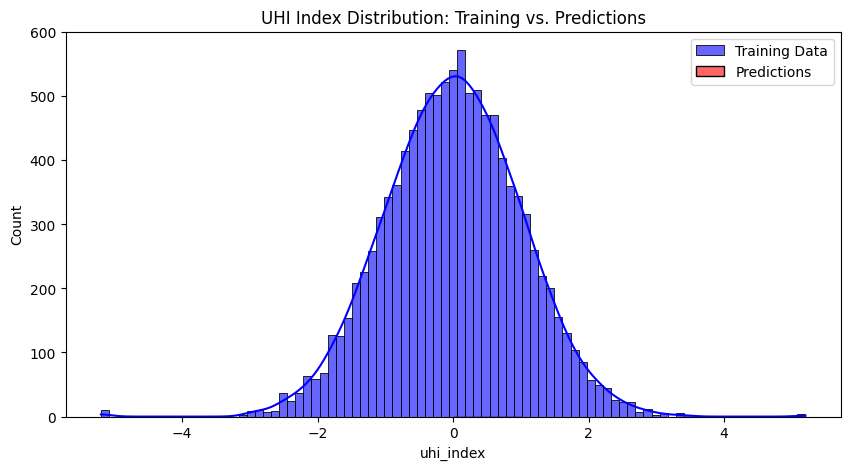

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load generated submission file
submission_df = pd.read_csv("../data/submission_vidit.csv")

# Load training data for comparison
train_df = pd.read_csv("../data/processed/UHI_Weather_Building_Sentinel_LST_Featured_Cleaned.csv")

# Distribution comparison
plt.figure(figsize=(10, 5))
sns.histplot(train_df["uhi_index"], label="Training Data", kde=True, color="blue", alpha=0.6)
sns.histplot(submission_df["UHI Index"], label="Predictions", kde=True, color="red", alpha=0.6)
plt.title("UHI Index Distribution: Training vs. Predictions")
plt.legend()
plt.show()

✅ Loaded Submission Data. Shape: (1040, 3)
📌 Available Columns: ['Longitude', 'Latitude', 'UHI Index']
📊 UHI Index Summary:
count    1040.000000
mean        0.999339
std         0.012768
min         0.975440
25%         0.987187
50%         1.004470
75%         1.008977
max         1.027790
Name: UHI Index, dtype: float64


/Users/viditgupta/UHI-Predictor/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


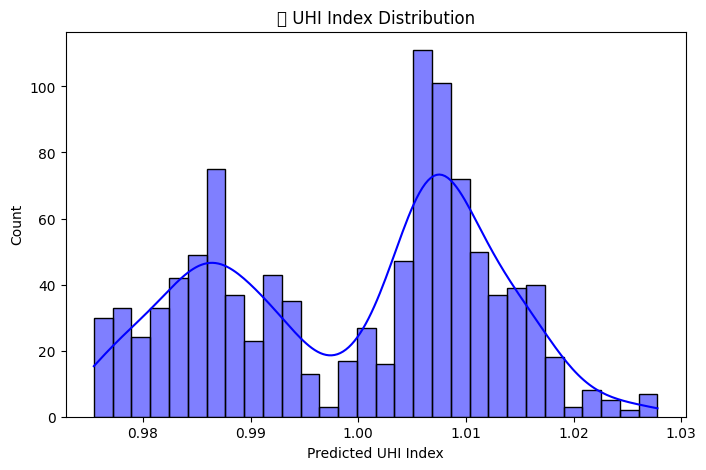

/Users/viditgupta/UHI-Predictor/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


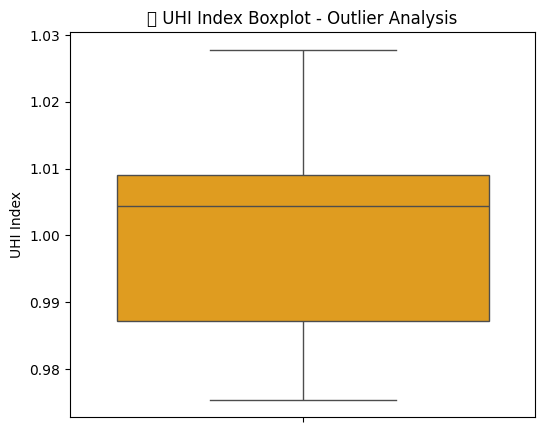

/var/folders/y0/slhcnc5d5ylcv5sf0glxtrvr0000gn/T/ipykernel_14883/3659389888.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(submission_df["UHI Index"], shade=True, color="green")
/Users/viditgupta/UHI-Predictor/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


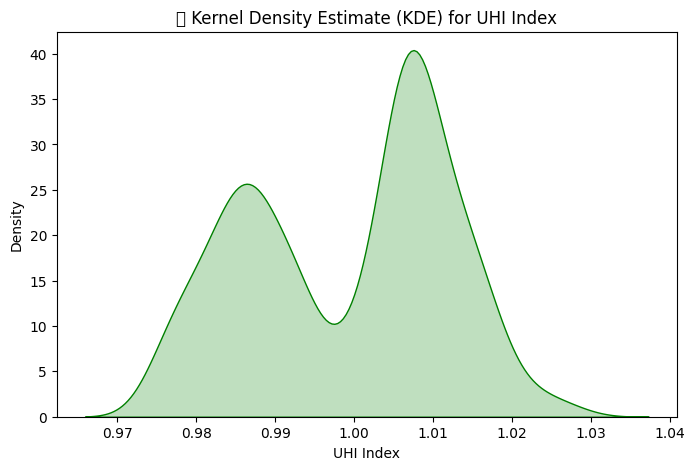

/var/folders/y0/slhcnc5d5ylcv5sf0glxtrvr0000gn/T/ipykernel_14883/3659389888.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
/Users/viditgupta/UHI-Predictor/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


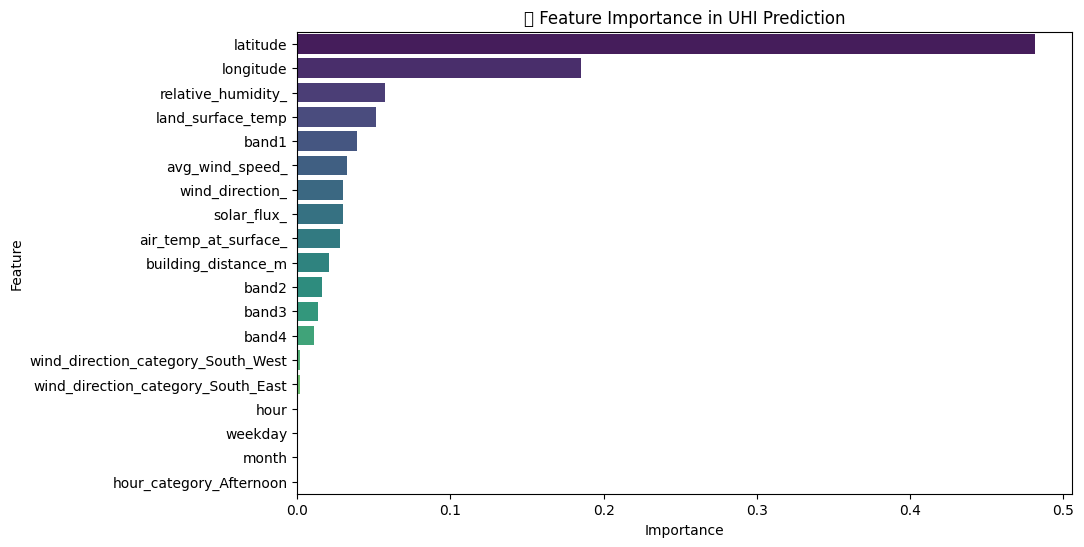

⚠️ Potential Outliers Detected: 0 values outside expected range
✅ Validated submission file saved as 'validated_submission.csv'


In [1]:
# 📌 Import Required Libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load Submission Data
submission_df = pd.read_csv("../data/submission_vidit.csv")

# ✅ Check Data
print(f"✅ Loaded Submission Data. Shape: {submission_df.shape}")
print(f"📌 Available Columns: {submission_df.columns.tolist()}")
print(f"📊 UHI Index Summary:\n{submission_df['UHI Index'].describe()}")

# ✅ **Step 1: Distribution Analysis**
plt.figure(figsize=(8, 5))
sns.histplot(submission_df["UHI Index"], bins=30, kde=True, color="blue")
plt.xlabel("Predicted UHI Index")
plt.title("📊 UHI Index Distribution")
plt.show()

# ✅ **Step 2: Boxplot to Check Outliers**
plt.figure(figsize=(6, 5))
sns.boxplot(y=submission_df["UHI Index"], color="orange")
plt.title("📦 UHI Index Boxplot - Outlier Analysis")
plt.show()

# ✅ **Step 3: KDE Plot for UHI Density**
plt.figure(figsize=(8, 5))
sns.kdeplot(submission_df["UHI Index"], shade=True, color="green")
plt.xlabel("UHI Index")
plt.title("📈 Kernel Density Estimate (KDE) for UHI Index")
plt.show()

# ✅ **Step 4: Feature Importance Analysis**
# Load Model (Use your trained model)
rf_model = joblib.load("../models/rf_model.pkl")  # Adjust path as needed
feature_names = joblib.load("../models/feature_names.pkl")

# Extract Feature Importance (If Using Random Forest or XGBoost)
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# ✅ **Step 5: Plot Feature Importance**
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("🔍 Feature Importance in UHI Prediction")
plt.show()

# ✅ **Step 6: Compare With Expected Range**
uhi_min, uhi_max = 0.9, 1.1  # Adjust based on expected UHI range
outliers = submission_df[(submission_df["UHI Index"] < uhi_min) | (submission_df["UHI Index"] > uhi_max)]
print(f"⚠️ Potential Outliers Detected: {outliers.shape[0]} values outside expected range")

# ✅ **Step 7: Save Processed Data**
submission_df.to_csv("validated_submission.csv", index=False)
print("✅ Validated submission file saved as 'validated_submission.csv'")